In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'transfer_learn'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, proximate_fp, calc_jacobian_at, get_model_params
from tools_lnd import make_dendro, gen_trials_from_model_dir, gen_X_from_model_dir, get_T_inds
from sklearn.decomposition import PCA
from sklearn import linear_model
from numpy import linalg as LA
from tools_lnd import get_D, make_h_trial_rule, get_model_params, plot_N

figpath = os.path.join(p,'code','overleaf','multitask-nets','v2_figs','transfer')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [2]:
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt


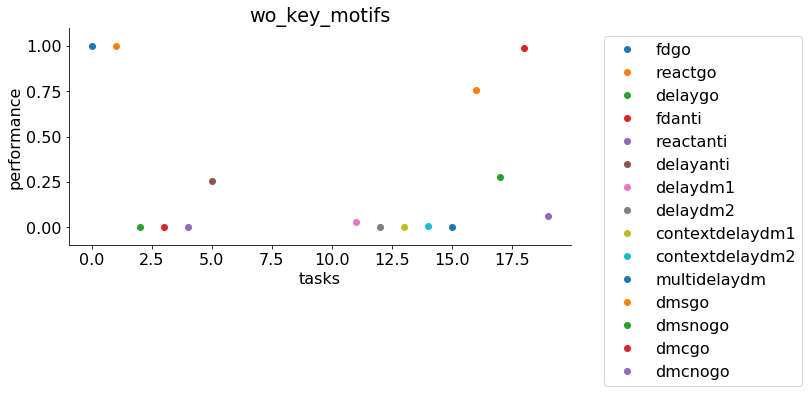

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt


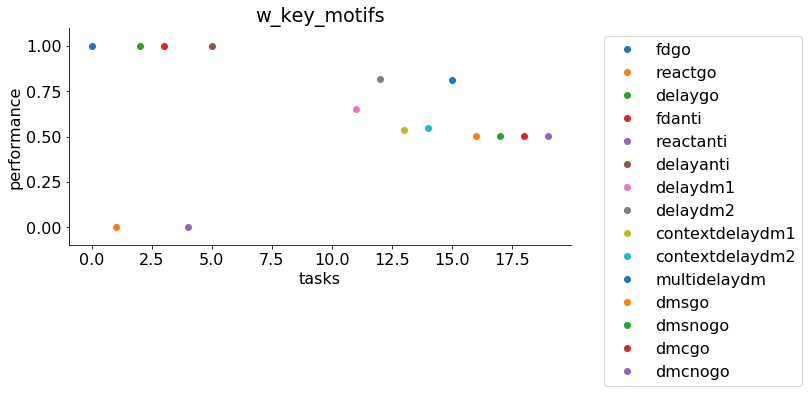

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_all_motifs/0_tasks/256_n_rnn/l2_w6.0_h6.0_/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_all_motifs/0_tasks/256_n_rnn/l2_w6.0_h6.0_/0/model.ckpt


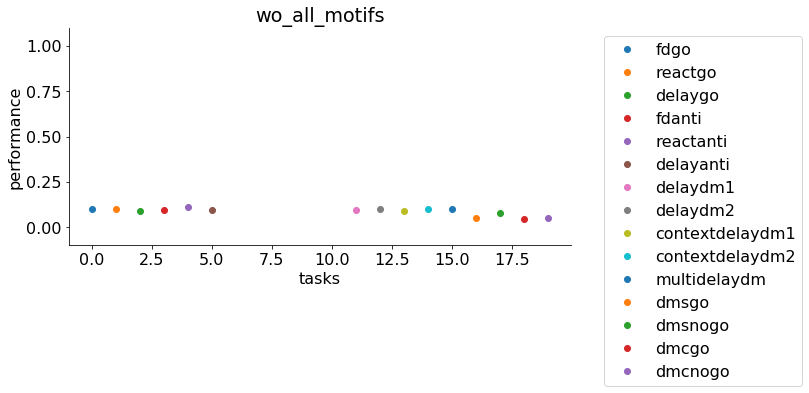

In [11]:
data_folder = 'data/rnn/multitask/'+net
# data_folder = 'code/multitask-nets/'+net+'/data/'
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0

rule_trains_set = {}
# rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
rule_trains_set['wo_key_motifs'] = ['fdgo', 'reactgo', 'dmcgo']
rule_trains_set['wo_all_motifs'] = []

all_rules = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delayanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

for rule_trains_label in rule_trains_set:
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,transfer_m)
    
    fig = plt.figure(figsize=(9, 4))
    plt.rcParams.update({'font.size': 16})
    ax = plt.subplot(121)
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]
        hparams = model.hp
        for rule in all_rules:#rule_trains_set['w_all_motifs']:#hparams['rule_trains']:
            trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128*16)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            perf = get_perf(y_hat_tf,trial.y_loc)
            ax = plt.subplot(121)
            plt.plot(np.where(trial.x[0,0,5:]), np.mean(perf),'o',label = rule)
            ax = plt.subplot(122)
            
    plt.title(rule_trains_label)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.ylim((-0.1,1.1))
    plt.xlabel('tasks')
    plt.ylabel('performance')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
      
    plt.show()

In [5]:
# ckpt_n_dir = os.path.join(m,'ckpts/model.ckpt-' + str(int(1)) + '.meta')
# model_params = get_model_params(m,ckpt_n_dir = ckpt_n_dir)

In [6]:
# model = Model(m)
# with tf.Session() as sess:
#     model.saver.restore(sess,ckpt_n_dir)

In [7]:
# w_in_diff
# for ckpt_n in range(0,14700,1000):
#     ckpt_n_dir = os.path.join(model_dir,'ckpts/model.ckpt-' + str(int(ckpt_n)) + '.meta')
#     w_in, _, w_out, _  = get_model_params(m,ckpt_n_dir = ckpt_n_dir)

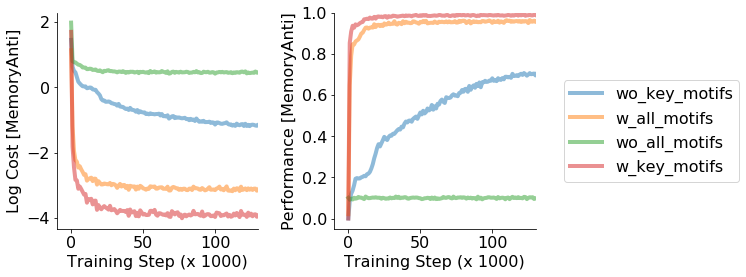

In [10]:
# data_folder = 'data/rnn/multitask/'+net
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7

rule_trains_set = {}
rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
rule_trains_set['wo_key_motifs'] = ['fdgo', 'reactgo', 'dmcgo']
rule_trains_set['wo_all_motifs'] = []

fig = plt.figure(figsize=(7, 3))
plt.rcParams.update({'font.size': 16})
task_list = ['delayanti',]
ax_cost = fig.add_axes([0,0,.4,1])
ax_perf = fig.add_axes([.55,0,.4,1])

for rule_trains_label in rule_trains_set:
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,transfer_m)
    
    fname = os.path.join(m, 'log.json')

    with open(fname, 'r') as f:
        log_all = json.load(f)
    for r in range(len(task_list)):
        
        plt.sca(ax_cost)
        x = np.log(log_all['cost_'+task_list[r]])
        plt.plot(x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
        ax_cost.set_xlabel('Training Step (x 1000)')
        ax_cost.set_ylabel('Log Cost [MemoryAnti]')
        plt.xlim([-10,130]) 
#         plt.ylim([-3.2,3]) 
        
        plt.sca(ax_perf)
        x = log_all['perf_'+task_list[r]]
        plt.plot(x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
        ax_perf.set_xlabel('Training Step (x 1000)')
        ax_perf.set_ylabel('Performance [MemoryAnti]')
        plt.xlim([-10,130]) 
        plt.ylim([-.05,1]) 
        

ax_perf.spines['top'].set_visible(False)
ax_perf.spines['right'].set_visible(False)
plt.legend(bbox_to_anchor=(1.1, 0.18))

ax_cost.spines['top'].set_visible(False)
ax_cost.spines['right'].set_visible(False)
plt.sca(ax_cost)


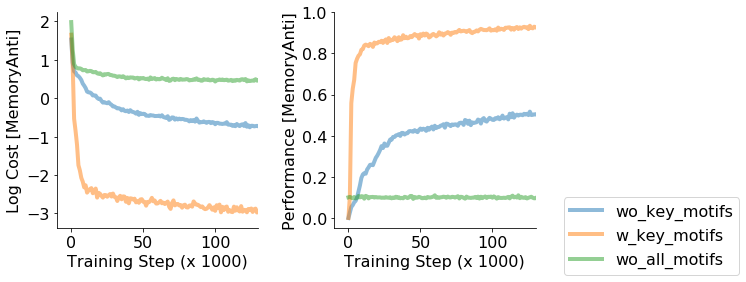

In [9]:
# data_folder = 'data/rnn/multitask/'+net
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7

rule_trains_set = {}
# rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
rule_trains_set['wo_key_motifs'] = ['fdgo', 'reactgo', 'dmcgo']
rule_trains_set['wo_all_motifs'] = []

fig = plt.figure(figsize=(7, 3))
plt.rcParams.update({'font.size': 16})
task_list = ['delayanti',]
ax_cost = fig.add_axes([0,0,.4,1])
ax_perf = fig.add_axes([.55,0,.4,1])

for rule_trains_label in rule_trains_set:
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,transfer_m)
    
    fname = os.path.join(m, 'log.json')

    with open(fname, 'r') as f:
        log_all = json.load(f)
    for r in range(len(task_list)):
        
        plt.sca(ax_cost)
        x = np.log(log_all['cost_'+task_list[r]])
        plt.plot(x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
        ax_cost.set_xlabel('Training Step (x 1000)')
        ax_cost.set_ylabel('Log Cost [MemoryAnti]')
        plt.xlim([-10,130]) 
#         plt.ylim([-3.2,3]) 
        
        plt.sca(ax_perf)
        x = log_all['perf_'+task_list[r]]
        plt.plot(x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
        ax_perf.set_xlabel('Training Step (x 1000)')
        ax_perf.set_ylabel('Performance [MemoryAnti]')
        plt.xlim([-10,130]) 
        plt.ylim([-.05,1]) 
        

ax_perf.spines['top'].set_visible(False)
ax_perf.spines['right'].set_visible(False)
plt.legend(bbox_to_anchor=(1.1, 0.18))

ax_cost.spines['top'].set_visible(False)
ax_cost.spines['right'].set_visible(False)
plt.sca(ax_cost)


In [17]:
from collections import OrderedDict
def make_h_all(m,mode = 'test',rules = []):
    model = Model(m, sigma_rec=0)
    with tf.Session() as sess:
        model.restore()

        h_all_byrule = OrderedDict()
        h_all_byepoch = OrderedDict()

        hp = model.hp
        n_hidden = hp['n_rnn']
        
        if len(rules)==0:
            rules = hp['rules']

        for rule in rules:
            trial = generate_trials(rule, hp, mode = mode, noise_on=False, batch_size = 100)
            feed_dict = tools.gen_feed_dict(model, trial, hp)
            h = sess.run(model.h, feed_dict=feed_dict)

            for e_name, e_time in trial.epochs.items():
                # if 'fix' not in e_name:  # Ignore fixation period
                h_all_byepoch[(rule, e_name)] = h[e_time[0]:e_time[1],:,:]
                
            h_all_byrule[rule] = h
                
    return h_all_byepoch, h_all_byrule


def make_pcs_taskset(m,taskset,n_components = 20):
    _, h_all_byrule = make_h_all(m,mode = 'test',rules = taskset)
    N = np.shape(h_all_byrule[taskset[0]])[2]

    X_use = np.reshape(h_all_byrule[taskset[0]][:],(-1,N))
    for rule in taskset[1:]:
        X_rule = h_all_byrule[rule]
        X_use = np.concatenate((X_use,np.reshape(X_rule[:],(-1,N))),axis = 0)

    from sklearn.decomposition import PCA
    pca = PCA(n_components = n_components)
    h_all_pca = pca.fit_transform(X_use)
    return pca

In [18]:
def make_D(m,task_set):

    h, trial, _ = make_h_trial_rule(m,task_set = task_set)
    _, _, w_out, _  = get_model_params(m)
    pca = make_pcs_taskset(m,task_set)

    ind = -1
    stim_angle = []
    target_angle = []
    r = []

    for ri in range(len(task_set)):
        rule = task_set[ri]
        T_inds = get_T_inds(trial[rule],'stim1')
        T_use = T_inds[ind]
        inds_use = np.min(trial[rule].stim_strength,axis=1)>.5
        r_temp = h[rule][T_use,inds_use,:].T
        stim1_locs = np.min(trial[rule].stim_locs[:,[0,2]],axis=1)
        stim_angle_temp = stim1_locs[inds_use]
        target_angle_temp = trial[rule].y_loc[-1,inds_use]

        if len(stim_angle)==0:
            stim_angle = stim_angle_temp
            target_angle = target_angle_temp
            r = r_temp
        else: 
            stim_angle = np.concatenate((stim_angle,stim_angle_temp))
            target_angle = np.concatenate((target_angle,target_angle_temp))
            r = np.concatenate((r,r_temp),axis = 1)

    y1 = np.expand_dims(np.sin(stim_angle),axis = 1)
    y2 = np.expand_dims(np.cos(stim_angle),axis = 1)
    stim_y = np.concatenate((y1,y2),axis=1)

    lm = linear_model.LinearRegression()
    model = lm.fit(stim_y,r.T)
    Beta = model.coef_
    B_stim,_ = LA.qr(Beta)

    y1 = np.expand_dims(np.sin(target_angle),axis = 1)
    y2 = np.expand_dims(np.cos(target_angle),axis = 1)
    target_y = np.concatenate((y1,y2),axis=1)

    lm = linear_model.LinearRegression()
    model = lm.fit(target_y,r.T)
    Beta = model.coef_
    B_target,_ = LA.qr(Beta)       
    
    return pca,w_out,B_stim,B_target

Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/mult

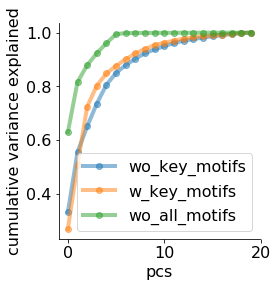

In [29]:
# data_folder = 'data/rnn/multitask/'+net
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7

rule_trains_set = {}
# rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
rule_trains_set['wo_key_motifs'] = ['fdgo', 'reactgo', 'dmcgo']
rule_trains_set['wo_all_motifs'] = []

fig = plt.figure(figsize=(7, 3))
plt.rcParams.update({'font.size': 16})
task_list = ['delayanti',]
ax_cost = fig.add_axes([0,0,.4,1])

for rule_trains_label in rule_trains_set:
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,transfer_m)
    
    fname = os.path.join(m, 'log.json')

    with open(fname, 'r') as f:
        log_all = json.load(f)
    for r in range(len(task_list)):
        
        pcs = make_pcs_taskset(m,task_list)
        x = np.cumsum(pcs.explained_variance_)/np.sum(pcs.explained_variance_)
        plt.plot(x,'-o',alpha = .5,linewidth = 4,label = rule_trains_label)
        ax_cost.set_xlabel('pcs')
        ax_cost.set_ylabel('cumulative variance explained')
        

ax_cost.spines['top'].set_visible(False)
ax_cost.spines['right'].set_visible(False)
plt.legend()


In [30]:
def plot_N(X, D, clist, linewidth = 1, alpha = .5, linestyle = '-', cmap_c = 'hsv',markersize = 10):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap(cmap_c)
    S = np.shape(X)[0]
    
    for s in range(S):

        if len(clist)==1:
            c = clist
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
        plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
        plt.plot(X_trial[0,0],X_trial[0,1],'o',c = c, linewidth = linewidth, alpha = alpha,markersize = markersize)

In [31]:
def plot_N3D(ax, X, D, clist, linewidth = 1, alpha = .5, linestyle = '-',markersize = 10):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap('rainbow')
    S = np.shape(X)[0]
    
    for s in range(S):

        if isinstance(clist, str) :
            c = clist
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
        ax.plot3D(X_trial[:,0],X_trial[:,1],X_trial[:,2],linestyle,c = c, linewidth = linewidth, alpha = alpha)
        ax.scatter(X_trial[0,0],X_trial[0,1],X_trial[0,2],s = markersize,c = 'k',marker = 'x')
        ax.scatter(X_trial[-1,0],X_trial[-1,1],X_trial[-1,2],s = markersize,c = 'k',marker = '^')

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/wo_all_motifs/0_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/wo_all_motifs/0_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/wo_all_motifs/0_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/wo_all_motifs/0_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
Vari

Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo

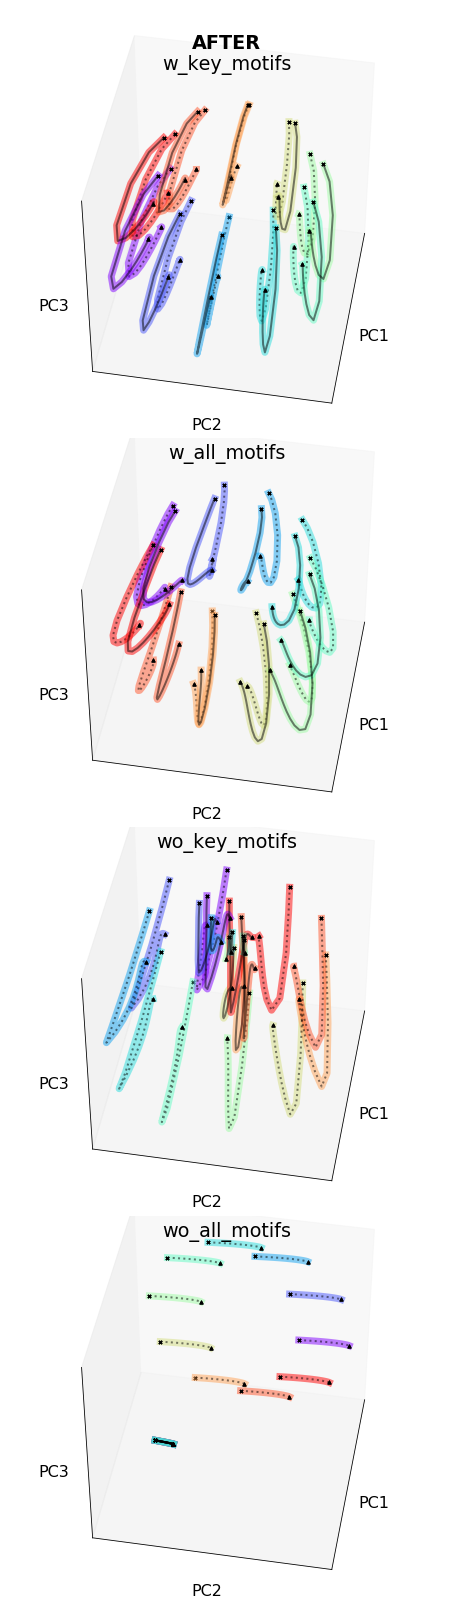

In [45]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 16})
task_set = ['fdgo',]

trial_set = range(0,80,8)
n_steps = -25
color_list = [.5,.5]
linestyles = [':','-']

fig = plt.figure(figsize=(6,3.6*6),tight_layout=True,facecolor='white')
keys = ['wo_all_motifs', 'wo_key_motifs', 'w_all_motifs', 'w_key_motifs']
    
for rti in range(len(keys)):
    rule_trains_label = keys[rti]
    
    ax_3D = fig.add_axes([0,rti*(1/len(keys)),1,1.1/len(keys)], projection='3d');
    
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,transfer_m)
    
    pca,w_out,B_stim,B_target = make_D(m,task_set)
    D_inds = {}
    D_inds[0] = pca.components_[:3,:]
    nr = 1
    nc = len(D_inds)

    axes_labels = {}
    axes_labels[0] = ['PC1','PC2','PC3']
    
    rules = ['fdgo','delayanti']
    _, h_all_byrule = make_h_all(m,mode = 'test',rules = rules)
    
    for ri in range(len(rules)):
        rule = rules[ri]
        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        X = np.transpose(h_all_byrule[rule][:,trial_set,:],(1, 0, 2))

        inds = {}
        inds['all'] = range(0,np.shape(X)[1])
        inds['stim'] = range(0,trial.epochs['go1'][0])
        inds['go'] = range(trial.epochs['go1'][0],np.shape(X)[1])
        
        for sp in range(len(D_inds)):
        
            D = D_inds[sp]
            X_subselect = X[:,inds['go'],:]
            clist = trial.y_loc[-1,trial_set]
            plot_N3D(ax_3D,X_subselect, D, clist,linestyle = '-',linewidth = 7,alpha = color_list[ri],markersize = 10)
            plot_N3D(ax_3D,X_subselect, D, 'k',linestyle = linestyles[ri],linewidth = 2,alpha = .5,markersize = 10)
            ax_3D.set_xlabel(axes_labels[sp][0])
            ax_3D.set_ylabel(axes_labels[sp][1])
            ax_3D.set_zlabel(axes_labels[sp][2])
            ax_3D.spines['top'].set_visible(False)
            ax_3D.spines['right'].set_visible(False)
            ax_3D.spines['bottom'].set_visible(False)
            ax_3D.spines['left'].set_visible(False)
            ax_3D.set_yticks([])
            ax_3D.set_xticks([])
            ax_3D.set_zticks([])
            plt.title(rule_trains_label)
            ax_3D.view_init(45, 10)
            plt.tight_layout()

plt.suptitle('AFTER',fontweight='bold',y = 1.01)
fig_dir = os.path.join(figpath,'posttrain')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

figname = rule_trains_label
plt.savefig(os.path.join(fig_dir,figname+'.pdf'))
plt.savefig(os.path.join(fig_dir,figname+'.png'))
plt.show()


Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_all_motifs/0_tasks/256_n_rnn/l2_w6.0_h6.0_/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_all_motifs/0_tasks/256_n_rnn/l2_w6.0_h6.0_/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_all_motifs/0_tasks/256_n_rnn/l2_w6.0_h6.0_/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_all_motifs/0_tasks/256_n_rnn/l2_w6.0_h6.0_/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/lea

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/soft

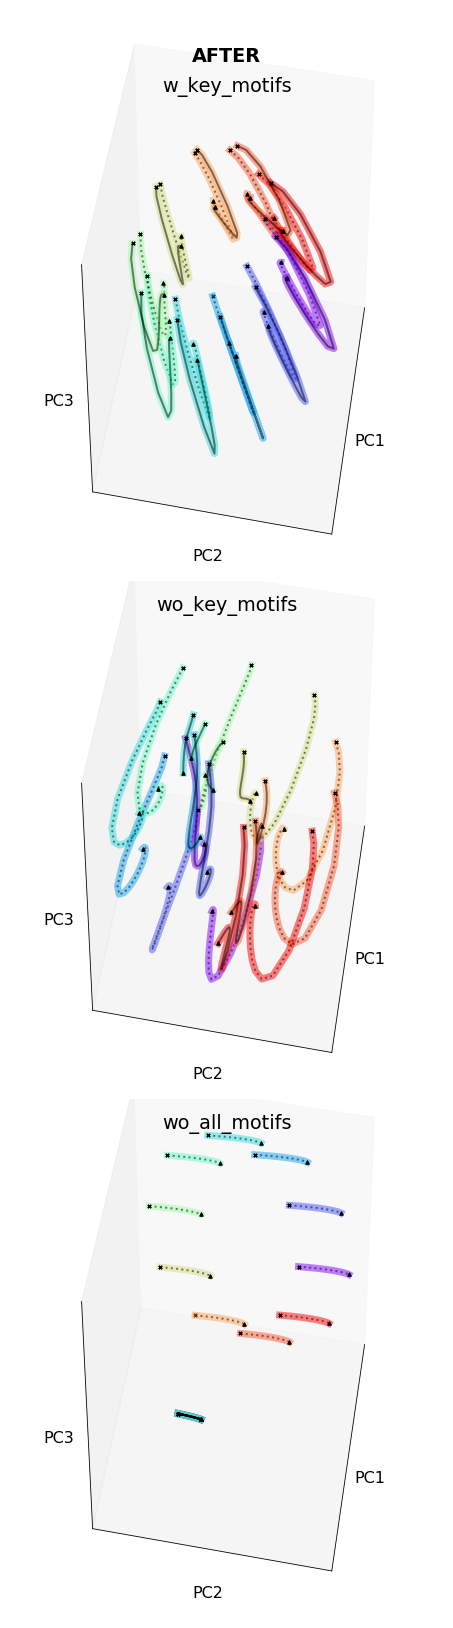

In [34]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 16})
task_set = ['fdgo',]

trial_set = range(0,80,8)
n_steps = -25
color_list = [.5,.5]
linestyles = [':','-']

fig = plt.figure(figsize=(6,3.6*6),tight_layout=True,facecolor='white')
keys = ['wo_all_motifs', 'wo_key_motifs', 'w_key_motifs']
    
for rti in range(len(keys)):
    rule_trains_label = keys[rti]
    
    ax_3D = fig.add_axes([0,rti*(1/len(keys)),1,1.1/len(keys)], projection='3d');
    
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,transfer_m)
    
    pca,w_out,B_stim,B_target = make_D(m,task_set)
    D_inds = {}
    D_inds[0] = pca.components_[:3,:]
    nr = 1
    nc = len(D_inds)

    axes_labels = {}
    axes_labels[0] = ['PC1','PC2','PC3']
    
    rules = ['fdgo','delayanti']
    _, h_all_byrule = make_h_all(m,mode = 'test',rules = rules)
    
    for ri in range(len(rules)):
        rule = rules[ri]
        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        X = np.transpose(h_all_byrule[rule][:,trial_set,:],(1, 0, 2))

        inds = {}
        inds['all'] = range(0,np.shape(X)[1])
        inds['stim'] = range(0,trial.epochs['go1'][0])
        inds['go'] = range(trial.epochs['go1'][0],np.shape(X)[1])
        
        for sp in range(len(D_inds)):
        
            D = D_inds[sp]
            X_subselect = X[:,inds['go'],:]
            clist = trial.y_loc[-1,trial_set]
            plot_N3D(ax_3D,X_subselect, D, clist,linestyle = '-',linewidth = 7,alpha = color_list[ri],markersize = 10)
            plot_N3D(ax_3D,X_subselect, D, 'k',linestyle = linestyles[ri],linewidth = 2,alpha = .5,markersize = 10)
            ax_3D.set_xlabel(axes_labels[sp][0])
            ax_3D.set_ylabel(axes_labels[sp][1])
            ax_3D.set_zlabel(axes_labels[sp][2])
            ax_3D.spines['top'].set_visible(False)
            ax_3D.spines['right'].set_visible(False)
            ax_3D.spines['bottom'].set_visible(False)
            ax_3D.spines['left'].set_visible(False)
            ax_3D.set_yticks([])
            ax_3D.set_xticks([])
            ax_3D.set_zticks([])
            plt.title(rule_trains_label)
            ax_3D.view_init(45, 10)
            plt.tight_layout()

plt.suptitle('AFTER',fontweight='bold',y = 1.01)
fig_dir = os.path.join(figpath,'posttrain')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

figname = rule_trains_label
plt.savefig(os.path.join(fig_dir,figname+'.pdf'))
plt.savefig(os.path.join(fig_dir,figname+'.png'))
plt.show()


In [21]:
import scipy
import pylab
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

def make_dendro_ax(axdendro,axmatrix,axdendro_top,axcolor,m,method = 'ward'):

    CA = clustering.Analysis(m, data_type='epoch')
    tick_names = [rule_name[key[0]]+' '+key[1] for key in CA.keys]

    # Generate features and distance matrix.
    D  = CA.h_normvar_all.T

    # Compute and plot dendrogram.
    Y = sch.linkage(D, method=method)

    max_d = 5 #threshold for task clusters
    clusters = fcluster(Y, max_d, criterion='distance')
    Z = sch.dendrogram(Y, orientation='left',labels = tick_names,
                       leaf_font_size = 11,color_threshold=max_d)
    axdendro.set_xticks([])
    # axdendro.set_yticks([])
    axdendro.spines['top'].set_visible(False)
    axdendro.spines['right'].set_visible(False)
    axdendro.spines['bottom'].set_visible(False)
    axdendro.spines['left'].set_visible(False)

    # Plot distance matrix.
    
    index_left = Z['leaves']
    tick_names_sorted = [tick_names[i] for i in index_left]
    D = D[index_left,:]

    # cel_num = [CA.ind_active[x] for x in index_top]
    
    Y = sch.linkage(D.T, method=method)
    max_d = 3 #threshold for cell clusters

    clusters = fcluster(Y, max_d, criterion='distance')
    Z = sch.dendrogram(Y, orientation='top',labels = clusters, #CA.ind_active #clusters
                       leaf_font_size = 11,color_threshold=max_d)

    # axdendro_top.set_xticks([])
    axdendro_top.set_yticks([])
    axdendro_top.spines['top'].set_visible(False)
    axdendro_top.spines['right'].set_visible(False)
    axdendro_top.spines['bottom'].set_visible(False)
    axdendro_top.spines['left'].set_visible(False)

    index_top = Z['leaves']
    D = D[:,index_top]
    clusters_sorted = clusters[index_top]
    im = axmatrix.matshow(D, aspect='auto', origin='lower',cmap='magma')
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    pylab.colorbar(im, cax=axcolor)

In [43]:
def make_dendro(m,method = 'ward'):

    CA = clustering.Analysis(m, data_type='epoch')
    tick_names = [rule_name[key[0]]+' '+key[1] for key in CA.keys]

    # Generate features and distance matrix.
    D  = CA.h_normvar_all.T

    # Compute and plot dendrogram.
    fig = pylab.figure(figsize=(6, 3))
    axdendro = fig.add_axes([0.09,0.1,0.05,0.75])
    Y = sch.linkage(D, method=method)

    max_d = 5 #threshold for task clusters
    clusters = fcluster(Y, max_d, criterion='distance')
    Z = sch.dendrogram(Y, orientation='left',labels = tick_names,
                       leaf_font_size = 11,color_threshold=max_d)
    axdendro.set_xticks([])
    # axdendro.set_yticks([])
    axdendro.spines['top'].set_visible(False)
    axdendro.spines['right'].set_visible(False)
    axdendro.spines['bottom'].set_visible(False)
    axdendro.spines['left'].set_visible(False)

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.37,0.1,0.6,0.75])
    index_left = Z['leaves']
    tick_names_sorted = [tick_names[i] for i in index_left]
    D = D[index_left,:]

    # cel_num = [CA.ind_active[x] for x in index_top]
    axdendro_top = fig.add_axes([0.37,.9,0.6,0.1])
    Y = sch.linkage(D.T, method=method)
    max_d = 3 #threshold for cell clusters

    clusters = fcluster(Y, max_d, criterion='distance')
    Z = sch.dendrogram(Y, orientation='top',labels = clusters, #CA.ind_active #clusters
                       leaf_font_size = 11,color_threshold=max_d)

    # axdendro_top.set_xticks([])
    axdendro_top.set_yticks([])
    axdendro_top.spines['top'].set_visible(False)
    axdendro_top.spines['right'].set_visible(False)
    axdendro_top.spines['bottom'].set_visible(False)
    axdendro_top.spines['left'].set_visible(False)

    index_top = Z['leaves']
    D = D[:,index_top]
    clusters_sorted = clusters[index_top]
    im = axmatrix.matshow(D, aspect='auto', origin='lower',cmap='magma')
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.975,0.1,0.01,0.8])
    pylab.colorbar(im, cax=axcolor)

Choosing 3 clusters
Choosing 11 clusters
Choosing 4 clusters
Choosing 3 clusters


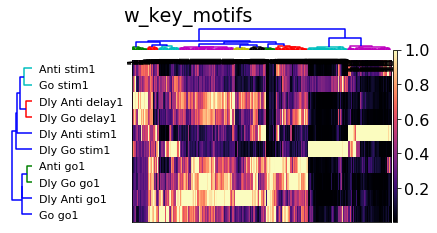

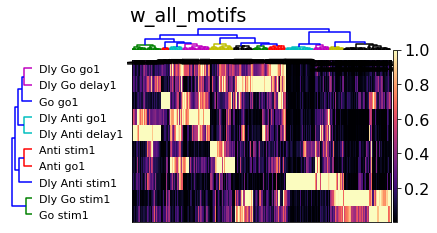

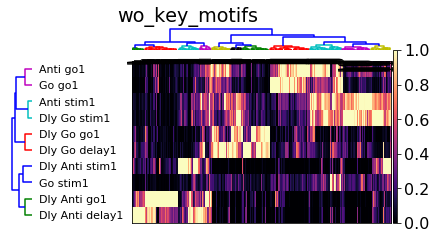

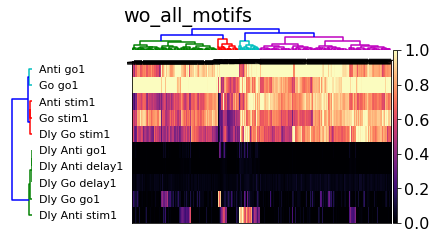

In [44]:
# fig = pylab.figure(figsize=(12, 6*len(keys)))

    
keys = ['w_key_motifs','w_all_motifs', 'wo_key_motifs', 'wo_all_motifs']
for rti in range(len(keys)):
    rule_trains_label = keys[rti]
    
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,transfer_m)

    sp_height = .8/len(keys)
    sp_width = .65

#     axdendro = fig.add_axes([0,(0.15+rti)*sp_height,0.2,sp_width*sp_height])
#     axmatrix = fig.add_axes([0.22,(0.1+rti)*sp_height,sp_width,sp_width*sp_height])
#     axdendro_top = fig.add_axes([0.22,(.9+rti)*sp_height,sp_width,0.2*sp_height])
#     axcolor = fig.add_axes([0.975,(0.1+rti)*sp_height,0.01,sp_width*sp_height])
    
    make_dendro(m,method = 'ward')
    plt.suptitle(rule_trains_label,y = 1.1)

In [11]:
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
n_rnn = int(256)
l2w = float(-6)
l2h = float(-6)
l1w = float(0)
l1h = float(0)
lr = float(-7)
seed = int(0)

folder = str(seed)
rule_trains_set = {}
rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
rule_trains_label = rule_trains_set.keys()[0]
ule_trains = rule_trains_set[rule_trains_label]
post_train = 'dmsnogo'

s = '_'
rule_trains_str = s.join(rule_trains)

start_from = str(len(rule_trains))+'_tasks'
models_dir = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/'

transfer_model_dir = os.path.join(models_dir,rnn_type,activation,init,str(len(rule_trains))+'_tasks',
                                  str(n_rnn)+'_n_rnn',
                                  'lr'+str(-lr)+'l2_w'+str(-l2w)+'_h'+str(-l2h)+'_'+rule_trains_str,folder)

m = os.path.join(PATH_YANGNET,'data',rnn_type,activation,init,rule_trains_label,str(len(rule_trains))+'_tasks',
                       str(n_rnn)+'_n_rnn','lr'+str(-lr)+'l2_w'+str(-l2w)+'_h'+str(-l2h)+'_'+rule_trains_str,
                       'post_train_'+post_train,folder)


In [22]:
model_params = {}
w_in, b_in, w_out, b_out  = get_model_params(m)

model_params['w_in'] = w_in
model_params['b_in'] = b_in
model_params['w_out'] = w_out
model_params['b_out'] = b_out

np.savez(os.path.join(m,'model_params.npz'),**model_params)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_dmsnogo:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/post_train_dmsnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/post_train_dmsnogo/0/model.ckpt


In [37]:
np.shape(w_in)

(22,)

In [23]:
pre = np.load(os.path.join(transfer_model_dir,'model_params.npz'))

In [29]:
np.shape(pre['w_in'][:5,:])

(5, 256)

In [31]:
np.max(w_in[0] - pre['w_in'][:5,:])

0.0

In [33]:
np.max(w_in[1] - pre['w_in'][5,:])

0.0

In [36]:
for x in range(1,len(w_in)):
    print(x,np.max(w_in[x] - pre['w_in'][x+4,:]))

1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 1.8065603
19 0.0
20 0.0
21 4.7174463


In [43]:
np.shape(w_in[21])

(256, 256)

In [45]:
np.max(w_in[21] - pre['w_in'][25:,:])

0.0

In [38]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_dmsnogo:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/post_train_dmsnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/data/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/post_train_dmsnogo/0/model.ckpt


In [39]:
var_list

[<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_stim:0' shape=(5, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/leaky_rnn_cell/kernel_input_fdgo:0' shape=(1, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/leaky_rnn_cell/kernel_input_reactgo:0' shape=(1, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delaygo:0' shape=(1, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/leaky_rnn_cell/kernel_input_fdanti:0' shape=(1, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/leaky_rnn_cell/kernel_input_reactanti:0' shape=(1, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/leaky_rnn_cell/kernel_input_dm1:0' shape=(1, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/leaky_rnn_cell/kernel_input_dm2:0' shape=(1, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdm1:0' shape=(1, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/leaky_rnn_cell/kernel_input_contextdm2:0' shape=(1, 256) dt